In [1]:
from src.reachability_analysis.simulation import get_test_label, run_scenario, get_data, get_initial_conditions
from src.clustering.run import load_config, get_cluster
from src.reachability_analysis.labeling_oracle import LABELS, LabelingOracleSINDData, LabelingOracleSVEAData, LabelingOracleROSData
from src.reachability_analysis.utils import load_data
import matplotlib.pyplot as plt
from PIL import Image
import os


/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/pypolycontain/operations.py:23: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/pypolycontain/conversions.py:32: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/home/sam/Desktop/P

In [2]:
ROOT = os.getcwd()
ROOT_RESOURCES = os.getcwd() + '/resources'

In [3]:
ROOT

'/home/sam/Desktop/Pedestrian_Project'

In [4]:
REVERSED_LABELS = {value: key for key, value in LABELS.items()}

In [5]:
LABELS

{'cross_left': 0,
 'cross_right': 1,
 'cross_straight': 2,
 'cross_illegal': 3,
 'crossing_now': 4,
 'not_cross': 5,
 'unknown': 6}

In [6]:
model_file = 'ROS_trained_on_SVEA'

index = 2
index_data = 0
folder = 'experiments'

In [7]:
#! /usr/bin/env python3

from src.reachability_analysis.simulation import get_test_config, get_test_label, get_cluster, get_initial_conditions, reachability_for_all_modes
from src.reachability_analysis.labeling_oracle import LabelingOracleSVEAData
from src.datasets.data import SVEAData
from src.transformer_model.model import create_model, evaluate
import json
import logging
import os
import rospy
from torch.utils.data import DataLoader
from src.datasets.data import data_factory, Normalizer
from src.datasets.masked_datasets import collate_unsuperv
from src.utils.load_data import load_task_datasets
from src.clustering.NearestNeighbor import AnnoyModel
import numpy as np

logging.basicConfig(
    format="%(asctime)s | %(levelname)s : %(message)s", level=logging.INFO
)
logger = logging.getLogger(__name__)


class TrajToZonotope:

    def __init__(self):
        
        CWD = os.path.dirname(os.path.abspath(__file__))
        while CWD.rsplit("/", 1)[-1] != "svea_vision":
            CWD = os.path.dirname(CWD)
        
        CWD = f'{CWD}/src/svea_vision/pedestrian_prediction'        
        self.config_path = f'{CWD}/resources/configuration.json'

        with open(self.config_path) as cnfg:
            self.config = json.load(cnfg)

        ROOT_RESOURCES = CWD + "/resources"

        self.config['original_data'] = False
        self.config['online_data'] = True
        self.config['pattern'] = None
        self.config['data_class'] = 'svea'
        self.config['eval_only'] = True
        self.config['val_ratio'] = 1
        self.config['output_dir'] = ROOT_RESOURCES + "/eval"
        self.config['save_dir'] = ROOT_RESOURCES + "/eval"
        self.config['tensorboard_dir'] = ROOT_RESOURCES + "/eval"

        self.data_oracle = SVEAData(self.config)
        self.nn_model = AnnoyModel(config=self.config)



    @staticmethod
    def zonotope_to_rectangle(z):
        """
        Convert a zonotope to its bounding rectangle.
        
        Parameters:
        z (zonotope): The zonotope to convert.

        Returns:
        (tuple): Top left and bottom right coordinates of the rectangle.
        """
        x = z.x[:, 0]
        G = z.G
        
        # Sum of the absolute values of the generators
        extent = np.sum(np.abs(G), axis=1)

        # Top left and bottom right coordinates
        bottom_left = x - extent
        top_right = x + extent
        
        return (bottom_left[0], bottom_left[1], top_right[0], top_right[1])



    def _callback(self, msg):
        """This method is a callback function that is triggered when a message is received.
        It interpolates person locations, stores the states of persons, and publishes
        the estimated person states to a 'person_state_estimation/person_states' topic.
        This implementation keeps sending the states of persons who have
        dropped out of frame, because the person might have dropped randomly.
        
        :param msg: message containing the detected persons
        :return: None"""
        self.data_oracle.process_message(msg)
        val_data = self.data_oracle.feature_df

        # Pre-process features
        if self.config["data_normalization"] != "none":
            logger.info("Normalizing data ...")
            normalizer = Normalizer(self.config["data_normalization"])
            val_data = normalizer.normalize(val_data)

        task_dataset, collate_fn = load_task_datasets(self.config)
        val_dataset = task_dataset(self.data_oracle.feature_df, self.data_oracle.all_IDs)

        # Dataloaders
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=self.config['batch_size'],
            shuffle=False,
            num_workers=self.config["num_workers"],
            pin_memory=True,
            collate_fn=lambda x: collate_fn(x, max_len=self.data_oracle.max_seq_len),
        )


        model, optimizer, trainer, val_evaluator, start_epoch = create_model(
            self.config, None, val_loader, self.data_oracle, logger, device='cpu'
        )

        aggr_metrics, embedding_data = evaluate(val_evaluator, config=self.config, save_embeddings=True)

        
        labeling_oracle = LabelingOracleSVEAData(self.config)
        #TODO are embeddings in the same order as person_states?
        for embedding, target, person_state in zip(embedding_data['embeddings'][0], embedding_data['targets'][0], msg.personstate):
            c = self.nn_model.get(embedding)
            test_cases = {f'c_{c}': f'Cluster: {c}'}
            pos = np.array([person_state.pose.position.x, person_state.pose.position.y])
            v = np.array([person_state.vx, person_state.vy])
            z, l, _b, _z = reachability_for_all_modes(pos=pos, vel=v, baseline=False, test_cases=test_cases, config=self.config, trajectory=target, show_plot=False, save_plot=None, _sind = labeling_oracle)
            rect = TrajToZonotope.zonotope_to_rectangle(z[0])


# if __name__ == "__main__":
#     traj_to_zonotope = TrajToZonotope()

In [8]:
config_path = '/home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-07-23_16-40-23_L0V/configuration.json'

with open(config_path) as cnfg:
    config = json.load(cnfg)

In [9]:
from src.datasets.data import ROSData

config['data_dir'] = 'resources/test'
bag_reader = ROSData(config)

2024-07-30 12:00:49,240 | INFO : Loading 1 datasets files using 1 parallel processes ...


resources/test
[INFO]  Successfully created the data folder resources/test/reprocessed_2024-07-16-14-54-22.


In [10]:
bag_reader.feature_df.ax

data_chunk_len
0      0.0
0      0.0
0      0.0
0      0.0
0      0.0
      ... 
424    0.0
424    0.0
424    0.0
424    0.0
424    0.0
Name: ax, Length: 18985, dtype: float64

In [11]:
bag_reader.all_df.track_id.unique()

array(['reprocessed_2024-07-16-14-54-22.bag_772',
       'reprocessed_2024-07-16-14-54-22.bag_798',
       'reprocessed_2024-07-16-14-54-22.bag_800',
       'reprocessed_2024-07-16-14-54-22.bag_801',
       'reprocessed_2024-07-16-14-54-22.bag_803',
       'reprocessed_2024-07-16-14-54-22.bag_805',
       'reprocessed_2024-07-16-14-54-22.bag_807',
       'reprocessed_2024-07-16-14-54-22.bag_808',
       'reprocessed_2024-07-16-14-54-22.bag_809',
       'reprocessed_2024-07-16-14-54-22.bag_810',
       'reprocessed_2024-07-16-14-54-22.bag_812',
       'reprocessed_2024-07-16-14-54-22.bag_815',
       'reprocessed_2024-07-16-14-54-22.bag_817',
       'reprocessed_2024-07-16-14-54-22.bag_818',
       'reprocessed_2024-07-16-14-54-22.bag_822',
       'reprocessed_2024-07-16-14-54-22.bag_825',
       'reprocessed_2024-07-16-14-54-22.bag_826',
       'reprocessed_2024-07-16-14-54-22.bag_827',
       'reprocessed_2024-07-16-14-54-22.bag_829',
       'reprocessed_2024-07-16-14-54-22.bag_831',


In [12]:
# import pandas as pd
# import os

# Assuming bag_reader.all_df is your dataframe
all_df = bag_reader.all_df

# Directory where the folders will be created
output_directory = "resources/test"

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Get unique track IDs
unique_track_ids = all_df['track_id'].unique()

# Iterate over each unique track_id
for track_id in unique_track_ids:
    # Create a directory for each track_id
    track_dir = os.path.join(output_directory, str(track_id))
    if not os.path.exists(track_dir):
        os.makedirs(track_dir)
    
    # Filter the dataframe for the current track_id
    track_df = all_df[all_df['track_id'] == track_id]
    
    # Save the filtered dataframe to a CSV file in the corresponding directory
    csv_path = os.path.join(track_dir, f"{track_id}.csv")
    track_df.to_csv(csv_path, index=False)

print("CSV files have been created for each unique track_id.")

CSV files have been created for each unique track_id.


In [13]:
# # Directory containing the .bag files
# input_directory = "bags"

# # Output CSV file path
# output_csv = "bags/aggregated_data.csv"

# # List to hold all the parsed dataframes
# aggregated_data = []

# # Crawl through all .bag files in the directory
# for filename in os.listdir(input_directory):
#     if filename.endswith(".bag"):
#         filepath = os.path.join(input_directory, filename)
#         # Load and clean the data from the .bag file
#         df = ROSData.load_single(filepath)
#         aggregated_data.append(df)

# # Concatenate all the parsed dataframes into a single dataframe
# final_df = pd.concat(aggregated_data, ignore_index=True)

# # Save the aggregated dataframe to a CSV file
# final_df.to_csv(output_csv, index=False)


### Zonotopes

In [14]:
ROOT_RESOURCES = ROOT + '/resources'
config = load_config(folder=folder, model_file=model_file, index=index, index_data=index_data)

In [15]:
config

{'activation': 'relu',
 'batch_size': 256,
 'comment': 'pretraining through imputation',
 'config_filepath': None,
 'console': False,
 'data_chunk_len': 50,
 'data_class': 'ros',
 'data_dir': '/home/sam/Desktop/Pedestrian_Project/bags',
 'data_normalization': 'none',
 'dropout': 0.0,
 'early_stopping_delta': 0.0,
 'early_stopping_patience': None,
 'embedding_dim': 128,
 'epochs': 1000,
 'eval_only': True,
 'exclude_feats': None,
 'experiment_name': 'ROS_experiment',
 'harden': True,
 'harden_step': 10,
 'hidden_dim': 512,
 'hyperparameter_tuning': False,
 'initial_timestamp': '2024-07-23_16-40-23',
 'l2_reg': 0.05,
 'load_model': '/home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-07-23_16-40-23_L0V/checkpoints/model_best.pth',
 'lr': 0.0005011190688592435,
 'lr_decay': 1.0,
 'lr_step': 1,
 'mask_distribution': 'bernoulli',
 'mask_mode': 'concurrent',
 'masking_ratio': 0.1,
 'max_grad_norm': 4.0,
 'mean_mask_length': 3,
 'n_proc': -1,
 'no_cuda': False,
 'normalizatio

In [16]:
config

{'activation': 'relu',
 'batch_size': 256,
 'comment': 'pretraining through imputation',
 'config_filepath': None,
 'console': False,
 'data_chunk_len': 50,
 'data_class': 'ros',
 'data_dir': '/home/sam/Desktop/Pedestrian_Project/bags',
 'data_normalization': 'none',
 'dropout': 0.0,
 'early_stopping_delta': 0.0,
 'early_stopping_patience': None,
 'embedding_dim': 128,
 'epochs': 1000,
 'eval_only': True,
 'exclude_feats': None,
 'experiment_name': 'ROS_experiment',
 'harden': True,
 'harden_step': 10,
 'hidden_dim': 512,
 'hyperparameter_tuning': False,
 'initial_timestamp': '2024-07-23_16-40-23',
 'l2_reg': 0.05,
 'load_model': '/home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-07-23_16-40-23_L0V/checkpoints/model_best.pth',
 'lr': 0.0005011190688592435,
 'lr_decay': 1.0,
 'lr_step': 1,
 'mask_distribution': 'bernoulli',
 'mask_mode': 'concurrent',
 'masking_ratio': 0.1,
 'max_grad_norm': 4.0,
 'mean_mask_length': 3,
 'n_proc': -1,
 'no_cuda': False,
 'normalizatio

In [17]:
config['data_dir']

'/home/sam/Desktop/Pedestrian_Project/bags'

In [18]:
config['pattern']

'none'

In [19]:
from src.datasets.plot import LL2XYProjector

proj = LL2XYProjector()

bottom_left = proj.latlon2xy(59.3465, 18.07040)
top_right = proj.latlon2xy(59.34570, 18.07292)

width = top_right[0] - bottom_left[0]
height = top_right[1] - bottom_left[1]

In [20]:
width, height

(161.15680819470435, -54.925453308969736)

In [21]:
# import pandas as pd
# df = pd.read_pickle('/home/sam/Desktop/Pedestrian_Project/resources/cluster_labels copy.pkl')

In [22]:
# plt.hist(df)

In [23]:
# import os

# # Path to the main directory containing subdirectories with CSV files
# main_directory = '/home/sam/Desktop/Pedestrian_Project/resources/test'

# # Find all directories containing CSV files in the main directory and its subdirectories
# csv_folders = set()
# for root, _, files in os.walk(main_directory):
#     for file in files:
#         if file.endswith('.csv'):
#             csv_folders.add(root)

In [24]:
# config['pattern'] = None

# for name in csv_folders:
#     config_test = config.copy()
#     config_test['data_dir'] = name
#     test_labeling_oracle = LabelingOracleROSData(config_test)

#     trajectory, l = get_test_label(test_labeling_oracle)
#     c = get_cluster(config_test, test_labeling_oracle)

#     if c != 0:
#         print(name)

In [25]:
config

{'activation': 'relu',
 'batch_size': 256,
 'comment': 'pretraining through imputation',
 'config_filepath': None,
 'console': False,
 'data_chunk_len': 50,
 'data_class': 'ros',
 'data_dir': '/home/sam/Desktop/Pedestrian_Project/bags',
 'data_normalization': 'none',
 'dropout': 0.0,
 'early_stopping_delta': 0.0,
 'early_stopping_patience': None,
 'embedding_dim': 128,
 'epochs': 1000,
 'eval_only': True,
 'exclude_feats': None,
 'experiment_name': 'ROS_experiment',
 'harden': True,
 'harden_step': 10,
 'hidden_dim': 512,
 'hyperparameter_tuning': False,
 'initial_timestamp': '2024-07-23_16-40-23',
 'l2_reg': 0.05,
 'load_model': '/home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-07-23_16-40-23_L0V/checkpoints/model_best.pth',
 'lr': 0.0005011190688592435,
 'lr_decay': 1.0,
 'lr_step': 1,
 'mask_distribution': 'bernoulli',
 'mask_mode': 'concurrent',
 'masking_ratio': 0.1,
 'max_grad_norm': 4.0,
 'mean_mask_length': 3,
 'n_proc': -1,
 'no_cuda': False,
 'normalizatio

2024-07-30 12:29:45,479 | INFO : Loading 1 datasets files using 1 parallel processes ...
/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-07-30 12:29:46,233 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_featur

Loaded model from /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-07-23_16-40-23_L0V/checkpoints/model_best.pth. Epoch: 896
Evaluating   0.0% | batch:         0 of         1	|	loss: 4459.89
Load data from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-07-23_16-40-23_L0V/eval/clusters
Load Annoy Model from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-07-23_16-40-23_L0V/eval/clusters/annoy_index.ann
CLUSTER 0
Name: reprocessed_2024-07-16-14-54-22.bag_817, {'l_0': 'Cluster: 0', 'c_0': 'Cluster: 0'}


Calculating reachable sets: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]
2024-07-30 12:30:18,211 | INFO : Loading 1 datasets files using 1 parallel processes ...


Area of zonotope:  184.1531  m^2
Area of (baseline) zonotope:  75.9089  m^2


Calculating reachable sets: 100%|██████████| 48/48 [00:02<00:00, 19.51it/s]


Area of zonotope:  184.1531  m^2


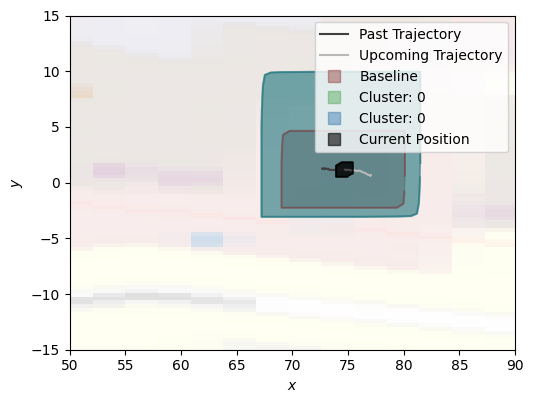

2024-07-30 12:30:22,169 | INFO : Loading 1 datasets files using 1 parallel processes ...
/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-07-30 12:30:22,632 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_featur

Loaded model from /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-07-23_16-40-23_L0V/checkpoints/model_best.pth. Epoch: 896
Evaluating   0.0% | batch:         0 of         1	|	loss: 4751.02
Load data from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-07-23_16-40-23_L0V/eval/clusters
Load Annoy Model from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-07-23_16-40-23_L0V/eval/clusters/annoy_index.ann
CLUSTER 0
Name: reprocessed_2024-07-16-14-54-22.bag_908, {'l_0': 'Cluster: 0', 'c_0': 'Cluster: 0'}


Calculating reachable sets: 100%|██████████| 48/48 [00:21<00:00,  2.26it/s]
2024-07-30 12:30:51,950 | INFO : Loading 1 datasets files using 1 parallel processes ...


Area of zonotope:  188.5419  m^2
Area of (baseline) zonotope:  63.4761  m^2


Calculating reachable sets: 100%|██████████| 48/48 [00:02<00:00, 19.69it/s]


Area of zonotope:  188.5419  m^2


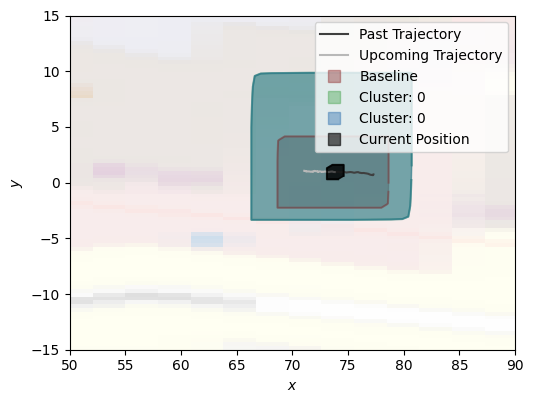

2024-07-30 12:30:56,030 | INFO : Loading 1 datasets files using 1 parallel processes ...
/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-07-30 12:30:56,492 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_featur

Loaded model from /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-07-23_16-40-23_L0V/checkpoints/model_best.pth. Epoch: 896
Evaluating   0.0% | batch:         0 of         1	|	loss: 4137.38
Load data from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-07-23_16-40-23_L0V/eval/clusters
Load Annoy Model from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-07-23_16-40-23_L0V/eval/clusters/annoy_index.ann
CLUSTER 0
Name: reprocessed_2024-07-16-14-54-22.bag_1015, {'l_0': 'Cluster: 0', 'c_0': 'Cluster: 0'}


Calculating reachable sets: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]
2024-07-30 12:31:27,541 | INFO : Loading 1 datasets files using 1 parallel processes ...


Area of zonotope:  180.7694  m^2
Area of (baseline) zonotope:  57.585  m^2


Calculating reachable sets: 100%|██████████| 48/48 [00:02<00:00, 19.81it/s]


Area of zonotope:  180.7694  m^2


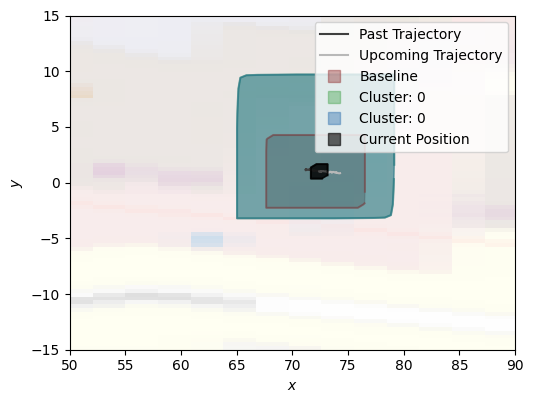

In [28]:
config['pattern'] = None

TEST_TRAJECTORIES = [
    'reprocessed_2024-07-16-14-54-22.bag_817',
    'reprocessed_2024-07-16-14-54-22.bag_908',
    'reprocessed_2024-07-16-14-54-22.bag_1015',
]
for name in TEST_TRAJECTORIES:
    config_test = config.copy()
    config_test['data_dir'] = ROOT_RESOURCES + f'/test/{name}'
    test_labeling_oracle = LabelingOracleROSData(config_test)

    trajectory, l = get_test_label(test_labeling_oracle)
    c = get_cluster(config_test, test_labeling_oracle)
    print('CLUSTER', c)
    test_cases = {f'l_{0}': f'Cluster: {0}', f'c_{c}': f'Cluster: {c}'}

    print(f"Name: {name},", test_cases)
    run_scenario(trajectory=trajectory, config=config, labels=test_cases, show_plot=True, save_plot=config_test['data_dir'])

Combine Final Images for Paper

FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/Desktop/Pedestrian_Project/resources/test/cross_illegal_8_11_1/use.png'

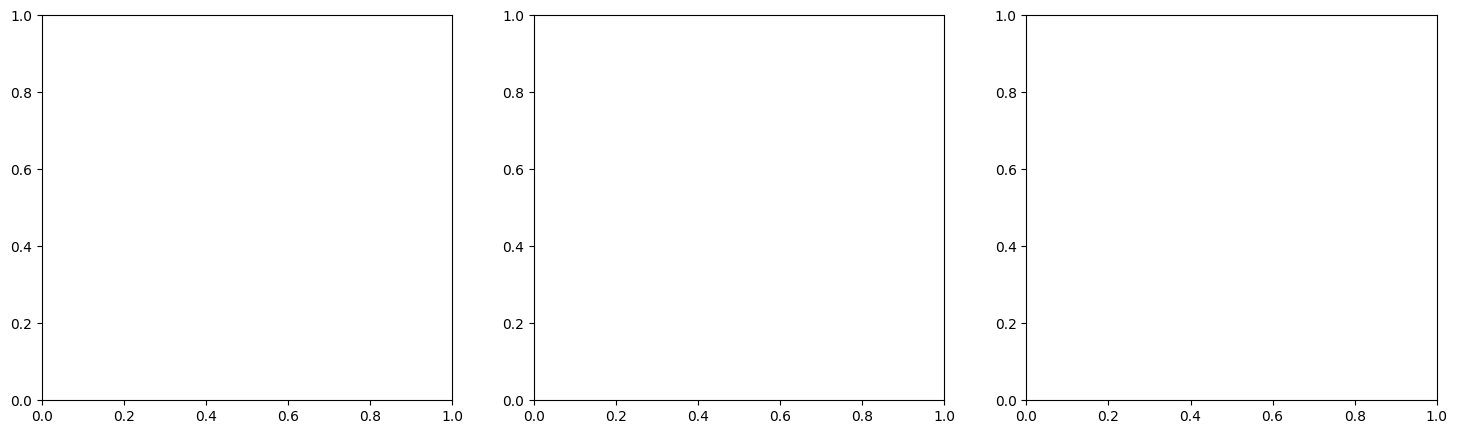

In [27]:
TEST_TRAJECTORIES = [
    'cross_illegal_8_11_1',
    'cross_left_8_6_4',
    'crossing_now_7_28_1',
]
def combine_images(image_paths, output_path):
    # Determine the number of images
    num_images = len(image_paths)
    
    # Create a matplotlib figure with multiple subplots
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images * 6, 5))
    
    # Check if there's only one subplot (axes could be an AxesSubplot object, not an array)
    if num_images == 1:
        axes = [axes]
    
    # Loop through the images and their respective axes
    for ax, img_path in zip(axes, image_paths):
        # Open the image file
        with Image.open(img_path) as img:
            # Convert the image file to an array
            ax.imshow(img)
            ax.axis('off')  # Hide axes
            
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust spacing between images if needed
    plt.savefig(output_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

# Example usage
image_paths = [
    ROOT_RESOURCES + f'/test/{TEST_TRAJECTORIES[0]}/use.png',
    ROOT_RESOURCES + f'/test/{TEST_TRAJECTORIES[2]}/use.png',
    ROOT_RESOURCES + f'/test/{TEST_TRAJECTORIES[1]}/use.png',
]
output_path = ROOT_RESOURCES + '/test/combined_image.jpg'

combine_images(image_paths, output_path)

### Clsuter picked for Zonotope

In [ ]:
c , l

(14, 4)

In [ ]:
_sind_, d, _, mapping = get_data(_load=True, config=config, test_case=(c, 'Cluster'))
_mode = mapping[c]
_mode

2024-06-24 13:09:13,848 | INFO : Loading 23 datasets files using 20 parallel processes ...


(14, 'Cluster') 113 (2986, 50, 6) (2986,)


13

In [ ]:
len(d[_mode])

113

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


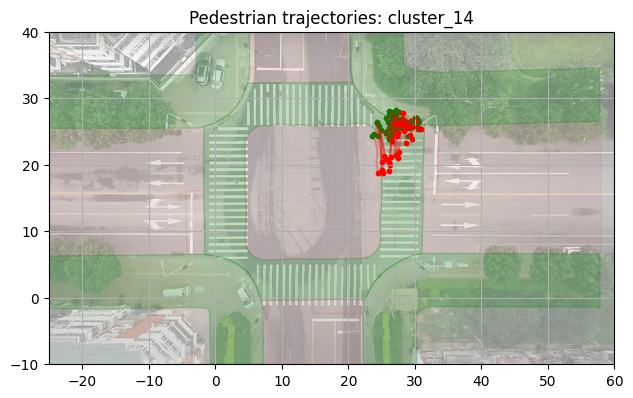

In [ ]:
_sind_.map.plot_dataset(pedestrian_data={i: data for i, data in enumerate(d[_mode])}, color='red', title=f'cluster_{c}', alpha_trajectories=0.3)